In [1]:
import pandas as pd
import scipy as sp
import pickle
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matrixprofile import *
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
sns.set(rc={'figure.figsize':(20.7,8.27)})

             Date     Open     High      Low    Close   Volume  OpenInt
0      1970-01-02   2.2972   2.3178   2.2972   2.2972    26437        0
1      1970-01-05   2.2972   2.2972   2.2544   2.2759    29887        0
2      1970-01-06   2.2759   2.2759   2.2342   2.2342   106900        0
3      1970-01-07   2.2342   2.2342   2.2342   2.2342    85061        0
4      1970-01-08   2.2342   2.2342   2.2139   2.2139    66669        0
...           ...      ...      ...      ...      ...      ...      ...
12069  2017-11-06  47.2000  47.6800  46.5300  47.2900  1725638        0
12070  2017-11-07  47.1100  47.2042  46.5400  46.9700  2168351        0
12071  2017-11-08  46.7300  46.7700  45.3700  45.8900  3347930        0
12072  2017-11-09  44.7100  44.7100  43.1100  43.3300  7671810        0
12073  2017-11-10  42.9300  44.4600  42.7500  43.0100  4463839        0

[12074 rows x 7 columns]


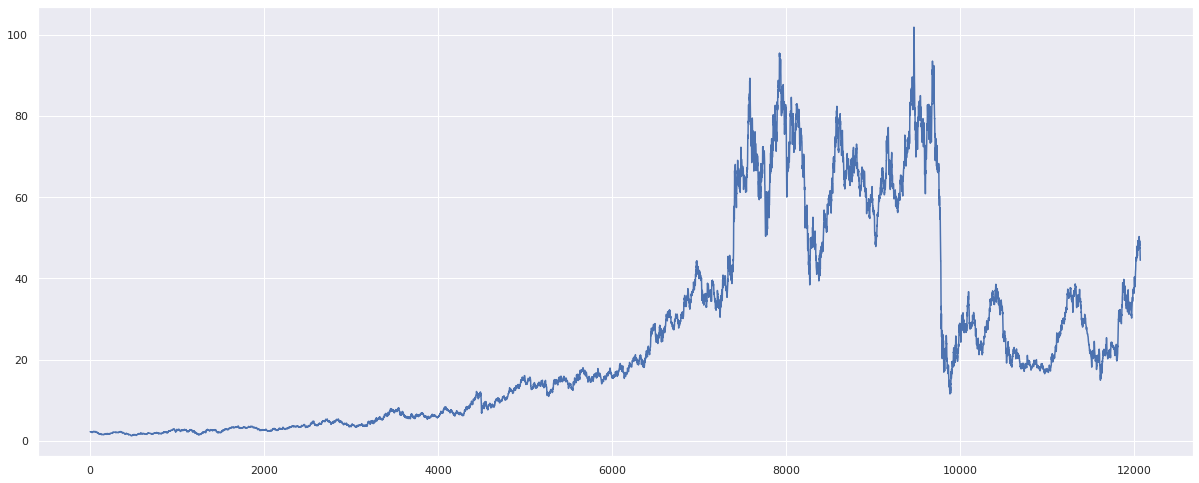

In [39]:
#Dataset https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs
df = pd.read_csv('price-volume-data-for-all-us-stocks-etfs/Stocks/aa.us.txt', sep=",", header=0)
print(df)
plt.plot(df['High'])

In [40]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(df[['High']].values)
df_normalized = pd.DataFrame(scaler.transform(df[['High']].values)).dropna().reset_index(drop=True)

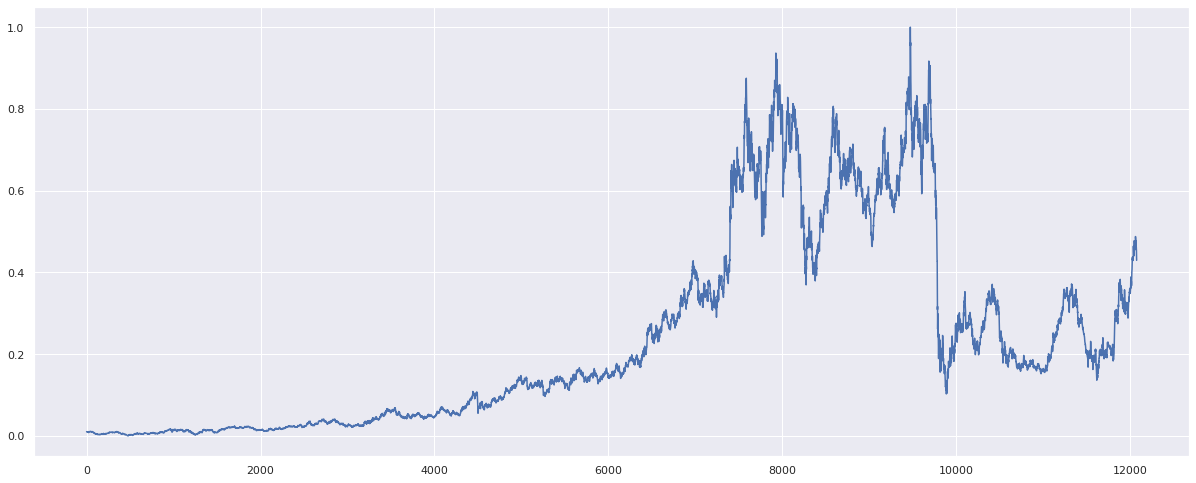

In [41]:
plt.plot(df_normalized)
plt.show()

#plt.plot(df_normalized_diff)

In [45]:
#Generate labels:
paa_length = 14
sensitivity = 0.05
epsilon = np.std(df_normalized.values.T[0])*sensitivity
labels = []
for i in range(0, len(df_normalized.values.T[0])-paa_length, paa_length):
    if df_normalized.values.T[0][i] + epsilon*0.5 < df_normalized.values.T[0][i+paa_length]:
        labels += [1.0] * paa_length #rise
    elif df_normalized.values.T[0][i] - epsilon*0.5 > df_normalized.values.T[0][i+paa_length]:
        labels += [-1.0] * paa_length #rise
    else:
        labels += [0.0] * paa_length #equal

#Get diff
df_normalized_diff = df_normalized.diff(paa_length).dropna()

#Shift labels
labels = labels[:-int(paa_length*0.5)]
df_normalized_diff = df_normalized_diff.iloc[int(paa_length*0.5):]

#Split
sz = df_normalized_diff.shape[0]
df_train = df_normalized_diff.iloc[0:int(sz*0.75)]
df_test = df_normalized_diff.iloc[int(sz*0.75):int(sz*0.875)]
df_valid = df_normalized_diff.iloc[int(sz*0.875):]

labels_train = labels[0:int(sz*0.75)]
labels_test = labels[int(sz*0.75):int(sz*0.875)]
labels_valid = labels[int(sz*0.875):]


#Find segements with homogeneous labeling for training
split = lambda df, chunk_size: np.array_split(df, len(df) // chunk_size + 1, axis=0)
segments_train = split(pd.DataFrame(labels_train).astype(int), paa_length)
segments_train_df = split(df_train, paa_length)
segments_train_homogeneous = []
segments_train_homogeneous_df = []
for index, segment in enumerate(segments_train):
    if segment[0].nunique() == 1 and segment.shape[0] == paa_length: #TODO Homogeneous length rmoved write that in paper
        segments_train_homogeneous.append(segment)
        segments_train_homogeneous_df.append(segments_train_df[index])
labels_train = pd.concat(segments_train_homogeneous, axis=0).values
df_train = pd.concat(segments_train_homogeneous_df, axis=0)


#Extract mtfs
m_length = paa_length 
max_motifs = 14
radius = int(paa_length*0.5)

def extract(data, m_length, max_motifs, radius):
    mp = matrixProfile.scrimp_plus_plus(data, m_length) #6 or 32
    mtfs, motif_d = motifs.motifs(data, mp, max_motifs=max_motifs, radius=radius)
    return mtfs, motif_d

#Select mtfs
def select(data, mtfs, motif_d, length, mode):
    sz = len([item for sublist in mtfs for item in sublist]) * length
    attr_vec = np.ndarray(shape=(sz, mode), dtype=float) #3
    count = 0
    tag = 1.0
    for i, motif in enumerate(mtfs):
        for index in motif:
            elem = np.array(data[index:index + length])
            for pos, x in enumerate(elem):
                attr_vec[count + pos][0] = x
                if mode == 6:
                    attr_vec[count + pos][0] = 0.0
                    attr_vec[count + pos][1] = tag #Add tag of found motif
                    attr_vec[count + pos][2] = elem.std() #Add std of found motif
                    attr_vec[count + pos][3] = sp.stats.skew(elem) #Add min of found motif
                    attr_vec[count + pos][4] = np.gradient(elem).mean() #Add max of found motif
                    attr_vec[count + pos][5] = motif_d[i] #Add motif distance

            count += length
        tag += 1.0

    attr_vec = pd.DataFrame(attr_vec)
    
    if mode == 1: #we are selecting relevant labels
        attr_vec = attr_vec.groupby(attr_vec.index // length).first() #try .agg(lambda x: x.value_counts().index[0]), aggregation by majority label
    if mode == 6: #then we are selecting relevant features
        attr_vec = attr_vec.groupby(attr_vec.index // length).mean()
    attr_vec = attr_vec.dropna()
    return attr_vec

mtfs, motif_d = extract(df_train.values.T[0], m_length, max_motifs, radius)
X_train = select(df_train.values.T[0], mtfs, motif_d, m_length, mode=6).reset_index(drop=True)
y_train = select(labels_train, mtfs, motif_d, m_length, mode=1).astype(int).reset_index(drop=True)
#print(y_train)

mtfs, motif_d = extract(df_test.values.T[0], m_length, max_motifs, radius)
X_test = select(df_test.values.T[0], mtfs, motif_d, m_length, mode=6).reset_index(drop=True)
y_test= select(labels_test, mtfs, motif_d, m_length, mode=1).astype(int).reset_index(drop=True)



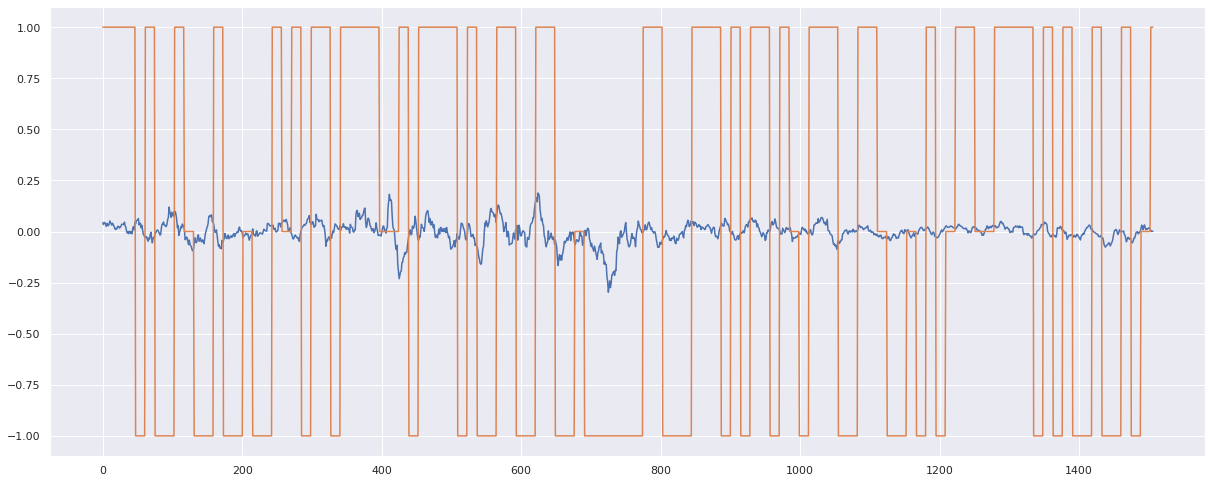

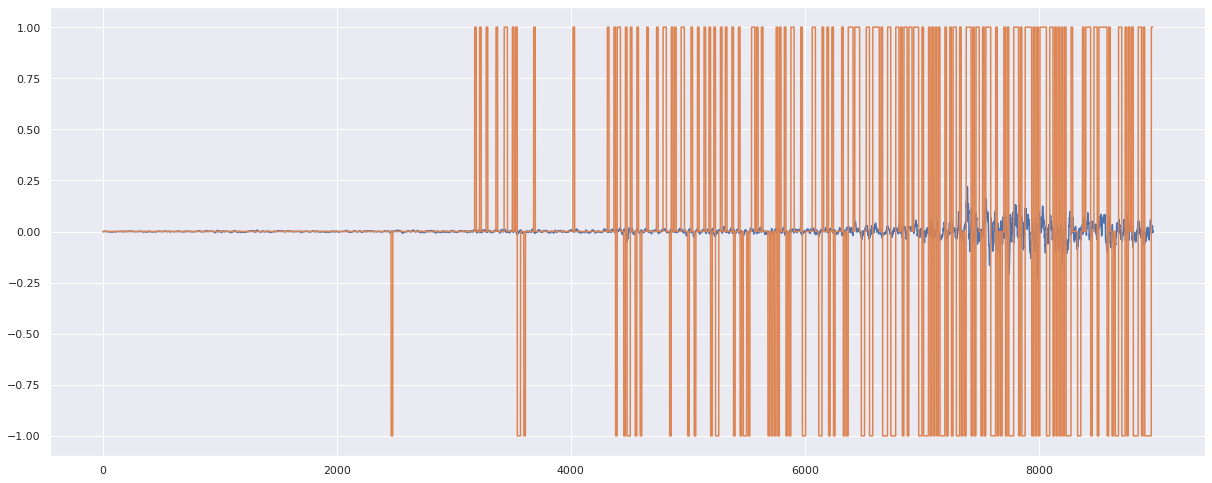

In [46]:

plt.plot(df_test.reset_index(drop=True))
plt.plot(labels_test)
plt.show()
plt.plot(df_train.reset_index(drop=True))
plt.plot(labels_train)
plt.show()

In [47]:
clf = RandomForestClassifier(random_state=0)
random_grid = {'bootstrap': [True, False],
               'max_depth': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [50, 130, 180, 230],
                'criterion': ['gini', 'entropy']}
clf = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
score = clf.score(X_test, y_test)
conf =confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
print('True')
print(y_test.values.T[0])
print('Predicted')
print(y_pred)
print('Diff')
print((np.array(y_pred).T-np.array(y_test).T)[0])
print('\n')
print(conf)
print(score)
print(report)
print(clf.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


True
[ 1  1  1 -1 -1  0 -1  1 -1  0 -1 -1  1  1 -1  1  1  1  1  0  0  1  1  1
  1  1 -1 -1  1 -1 -1  1 -1  0  0 -1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1
  1  1  0  0  1 -1 -1 -1 -1 -1  0  1 -1  0  1  0  0  1  1  1 -1 -1 -1 -1
 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1 -1  0  0  1  1  1  1  1  0 -1  1  1
 -1  1  1  1 -1  1  1 -1 -1 -1 -1  1  1 -1  1  1 -1  1 -1  1 -1  1  1  1
  1  1  1  0 -1 -1  1  0  1  1  1  1  1 -1 -1  1 -1  1 -1  1  0  1 -1 -1
  1  1 -1 -1 -1  1  1]
Predicted
[ 1  1 -1  1 -1 -1  1 -1  1  1  1 -1 -1  1  1  1  1 -1 -1  1  1  1 -1 -1
 -1 -1  1  1 -1 -1  1  1  1  1 -1  1  1 -1 -1 -1 -1  1  1  0  1 -1 -1 -1
 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1  0  1 -1  0  1 -1 -1 -1 -1 -1  1
  1 -1  1  1  1 -1  1 -1  1 -1  1  1  1 -1  1  1  1 -1 -1 -1  1  1  1 -1
  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1 -1 -1  1 -1  1 -1 -1  1
  1  1  1  0 -1  1  1  0  1  1  1  1  0 -1  1  0  1 -1 -1  1  1  1 -1  1
  1  1  1 -1  1 -1 -1]
Diff
[ 0  0 -2  2  0 -1  2 -2  2  1  2  0 -2  0  2  0  0 -2 -2 

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished
/home/lorenz/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
